In [9]:
import sys
import os.path
from math import *
import numpy as np
import pandas as pd
import sklearn.preprocessing
import sklearn.decomposition
import sklearn.cross_decomposition
import sklearn.mixture
import sklearn.neighbors
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
current_palette_4 = sns.color_palette("hls", 4)
sns.set_palette(current_palette_4)
import LSTM_tools as tools
import warnings
warnings.filterwarnings('ignore')
data_path = 'data'
plot_path = 'plots'

Using TensorFlow backend.


In [23]:
## Settings
'''Keep merge_data=True if you have set n_classes (in preprocessing) such that 
there are classes in the test set that do not have instances in the training set'''
merge_data = True
'''This means that we are using all the features, 
if you want to limit the model to use only a subset of proncipal components, give them to this parameter as a list
The list should always include "id", "cycle", "status" columns'''
usecols = None
sn = 3
setnumber = 'FD00'+str(sn)

## SVM SETTINGS
outlier_threshold = 0.1

In [24]:
## Read preprocessed data
train, test, validate = tools.read_preprocessed_data(setnumber, usecols, merge_data)
status_labels = train.status.unique()

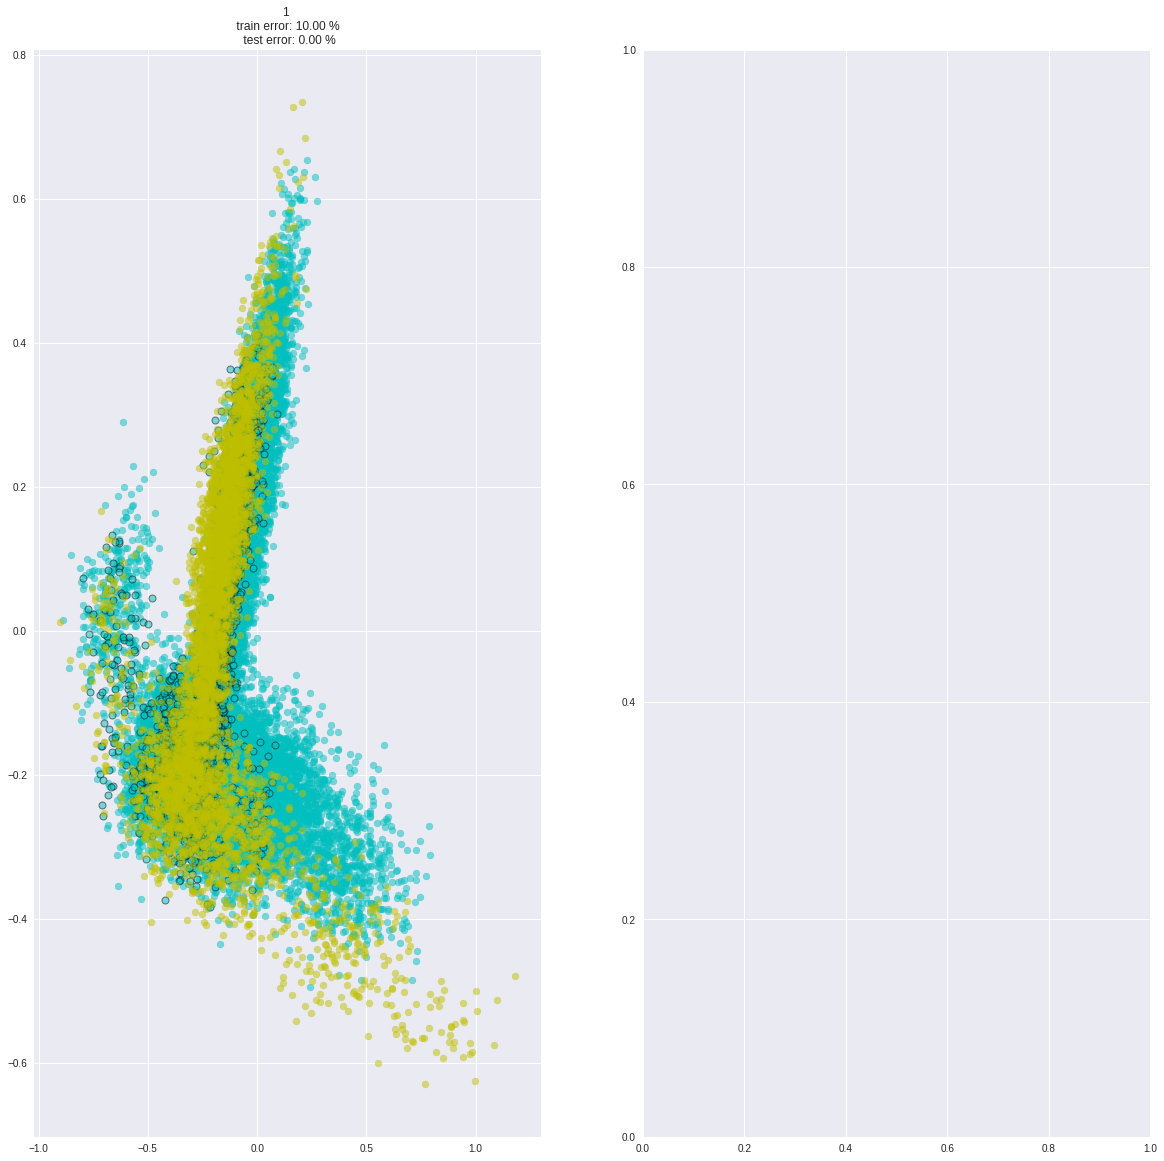

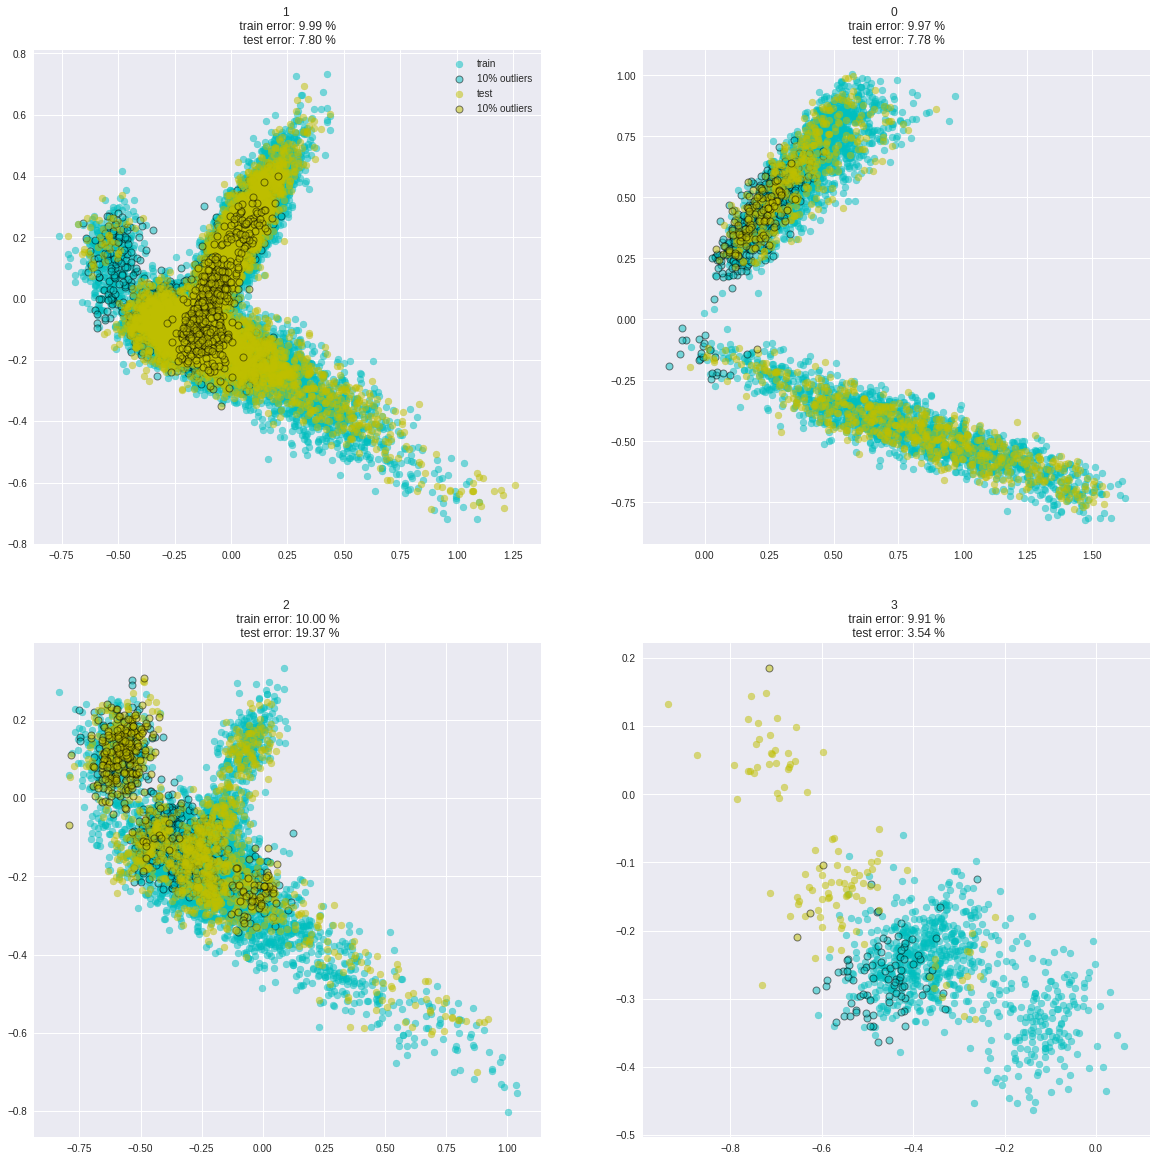

In [25]:
## USE SVM OUTLIER DETECTION
from sklearn import svm
fig, axs = plt.subplots(int(len(status_labels)/2.),2, figsize=(20,20))
axs = axs.flatten()
for i, reference_status in enumerate(status_labels):
    X = train.loc[train.status==reference_status]
    Xtest = test.loc[test.status==reference_status]
    X['status'] = 1
    Xtest['status'] = 1
    clf = svm.OneClassSVM(nu=outlier_threshold, kernel="poly", degree=5).fit(X.values)
    y_pred_train = clf.predict(X)
    y_pred_test = clf.predict(Xtest)
    X['predict'] = y_pred_train
    Xtest['predict'] = y_pred_test
    n_error_train = y_pred_train[y_pred_train == -1].size
    n_error_test = y_pred_test[y_pred_test == -1].size

    train_normal = X.loc[X.predict==1]
    train_outlier = X.loc[X.predict==-1]
    test_normal = Xtest.loc[Xtest.predict==1]
    test_outlier = Xtest.loc[Xtest.predict==-1]

    axs[i].scatter(train_normal.comp_1, train_normal.comp_2, 
                   facecolor='c', label='train', alpha=0.5)
    axs[i].scatter(train_outlier.comp_1, train_outlier.comp_2, 
                   facecolor='c', edgecolor='k', lw=1, 
                   label='%d%% outliers'%(outlier_threshold*100.), alpha=0.5)
    axs[i].scatter(test_normal.comp_1, test_normal.comp_2, 
                   facecolor='y', label='test', alpha=0.5)
    axs[i].scatter(test_outlier.comp_1, test_outlier.comp_2, 
                   facecolor='y', edgecolor='k', lw=1, 
                   label='%d%% outliers'%(outlier_threshold*100.), alpha=0.5)

    axs[i].set_title('%s \n train error: %.2f %% \n test error: %.2f %%'%(reference_status, n_error_train*1. / X.shape[0] * 100., n_error_test*1. / Xtest.shape[0] * 100.))

axs[0].legend()
plt.savefig(os.path.join(plot_path, 'outliers_%d_percent_%s.png'%(outlier_threshold*100, setnumber)))
plt.show()